In [0]:
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler, random_split
import torch.nn as nn

from PIL import Image
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files 
import json
%matplotlib inline

import xml.etree.ElementTree as ET
!ls

sample_data


In [0]:
uploaded=files.upload()
for filename in uploaded.keys():
    print('Upload {} : {}'.format(filename,len(uploaded[filename])))

with open('./kaggle.json') as json_file:
    api_token=json.loads(json_file.read())
os.environ['KAGGLE_USERNAME']=api_token['username']
os.environ['KAGGLE_KEY']=api_token['key']
!kaggle datasets download -d jessicali9530/stanford-dogs-dataset --unzip --force

Saving kaggle.json to kaggle.json
Upload kaggle.json : 64
 98% 737M/750M [00:15<00:00, 37.9MB/s]
100% 750M/750M [00:15<00:00, 49.9MB/s]


In [0]:
if torch.cuda.is_available():
    device=torch.device('cuda')
else:
    device=torch.device('cpu')
device

device(type='cuda')

In [0]:
def crop_image(breed,dog,data_dir):
    img=plt.imread(os.path.join(data_dir,'images','Images',breed,dog)+'.jpg')
    tree=ET.parse(os.path.join(data_dir,'annotations','Annotation',breed,dog))
    xmin=int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
    xmax=int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
    ymin=int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
    ymax=int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
    img=img[ymin:ymax,xmin:xmax,:]
    return img

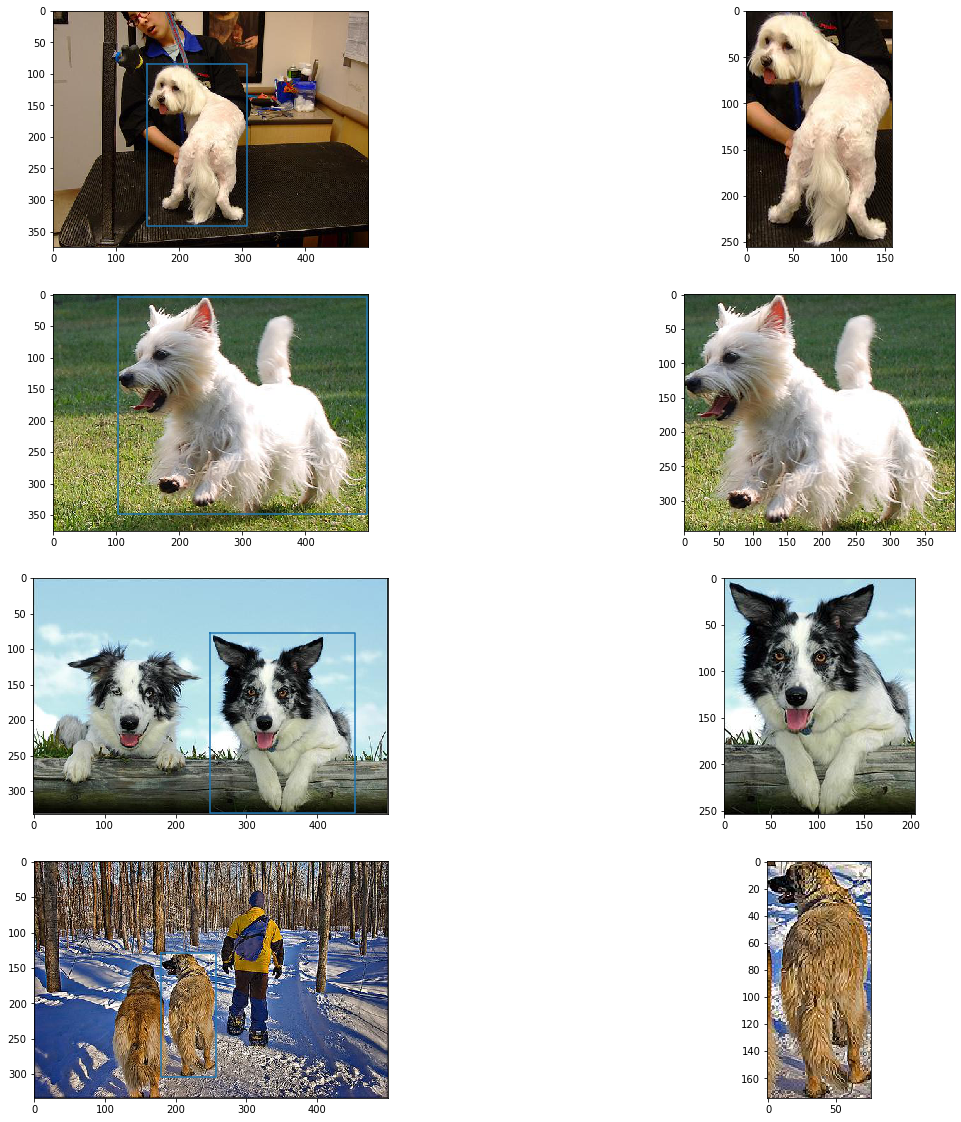

In [0]:
data_dir='.'
breed_list=os.listdir(os.path.join(data_dir,'images','Images'))
plt.figure(figsize=(20,20))
for i in range(4):
    plt.subplot(421+(i*2))
    breed=np.random.choice(breed_list)
    dog=np.random.choice(os.listdir(os.path.join(data_dir,'annotations','Annotation',breed)))
    img=plt.imread(os.path.join(data_dir,'images','Images',breed,dog)+'.jpg')
    plt.imshow(img)
    tree=ET.parse(os.path.join(data_dir,'annotations','Annotation',breed,dog))
    xmin=int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
    xmax=int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
    ymin=int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
    ymax=int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
    plt.plot([xmin,xmax,xmax,xmin,xmin],[ymin,ymin,ymax,ymax,ymin])
    crop_img=crop_image(breed,dog,data_dir)
    plt.subplot(422+(i*2))
    plt.imshow(crop_img)

In [0]:
if 'data' not in os.listdir():
    os.mkdir('data')
for breed in breed_list:
    os.mkdir('data/' + breed)
print('Created {} folders to store cropped images of the different breeds.'.format(len(os.listdir('data'))))

Created 120 folders to store cropped images of the different breeds.


In [0]:
for breed in os.listdir('data'):
    for file in os.listdir(os.path.join(data_dir,'annotations','Annotation', breed)):
        img = Image.open(os.path.join(data_dir,'images','Images',breed, file)+'.jpg')
        tree = ET.parse(os.path.join(data_dir,'annotations','Annotation',breed,file))
        xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
        xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
        ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
        ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
        img = img.crop((xmin,ymin,xmax,ymax))
        img = img.convert('RGB')
        img.save('data/' + breed + '/' + file + '.jpg')

In [0]:
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.Resize(256),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [0]:
batch_size = 128

all_data = datasets.ImageFolder(root='data')
train_data_len = int(len(all_data)*0.8)
valid_data_len = int((len(all_data) - train_data_len)/2)
test_data_len = int(len(all_data) - train_data_len - valid_data_len)
train_data, val_data, test_data = random_split(all_data, [train_data_len, valid_data_len, test_data_len])
train_data.dataset.transform = image_transforms['train']
val_data.dataset.transform = image_transforms['test']
test_data.dataset.transform = image_transforms['test']
print(len(train_data), len(val_data), len(test_data))

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

16464 2058 2058


In [0]:
trainiter = iter(train_loader)
features, labels = next(trainiter)
print(features.shape, labels.shape)

torch.Size([128, 3, 224, 224]) torch.Size([128])


In [0]:
model = models.googlenet(pretrained=True)
model.aux_logits=False
model

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 87.5MB/s]


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [0]:
for param in model.parameters():
    param.requires_grad = False

In [0]:
n_classes = 120
n_inputs = model.fc.in_features
model.fc=nn.Linear(n_inputs,n_classes)

In [0]:
model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [0]:
model.class_to_idx=all_data.class_to_idx
model.idx_to_class={
    idx:class_ for class_,idx in model.class_to_idx.items()
}
list(model.idx_to_class.items())

[(0, 'n02085620-Chihuahua'),
 (1, 'n02085782-Japanese_spaniel'),
 (2, 'n02085936-Maltese_dog'),
 (3, 'n02086079-Pekinese'),
 (4, 'n02086240-Shih-Tzu'),
 (5, 'n02086646-Blenheim_spaniel'),
 (6, 'n02086910-papillon'),
 (7, 'n02087046-toy_terrier'),
 (8, 'n02087394-Rhodesian_ridgeback'),
 (9, 'n02088094-Afghan_hound'),
 (10, 'n02088238-basset'),
 (11, 'n02088364-beagle'),
 (12, 'n02088466-bloodhound'),
 (13, 'n02088632-bluetick'),
 (14, 'n02089078-black-and-tan_coonhound'),
 (15, 'n02089867-Walker_hound'),
 (16, 'n02089973-English_foxhound'),
 (17, 'n02090379-redbone'),
 (18, 'n02090622-borzoi'),
 (19, 'n02090721-Irish_wolfhound'),
 (20, 'n02091032-Italian_greyhound'),
 (21, 'n02091134-whippet'),
 (22, 'n02091244-Ibizan_hound'),
 (23, 'n02091467-Norwegian_elkhound'),
 (24, 'n02091635-otterhound'),
 (25, 'n02091831-Saluki'),
 (26, 'n02092002-Scottish_deerhound'),
 (27, 'n02092339-Weimaraner'),
 (28, 'n02093256-Staffordshire_bullterrier'),
 (29, 'n02093428-American_Staffordshire_terrier'),


In [0]:
def train(model,
         criterion,
         optimizer,
         train_loader,
         val_loader,
         save_location,
         early_stop=3,
         n_epochs=20,
         print_every=2):
    valid_loss_min = np.Inf
    stop_count = 0
    valid_max_acc = 0
    history = []
    model.epochs = 0

    for epoch in range(n_epochs):
        
        train_loss = 0
        valid_loss = 0

        train_acc = 0
        valid_acc = 0

        model.train()
        ii = 0

        for data, label in train_loader:
            ii += 1
            data, label = data.cuda(), label.cuda()
            optimizer.zero_grad()
            output = model(data)

            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * data.size(0)

            _, pred = torch.max(output, dim=1) 
            correct_tensor = pred.eq(label.data.view_as(pred)) 
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            train_acc += accuracy.item() * data.size(0)
            if ii%10 == 0:
                print(f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete.')

        model.epochs += 1
        with torch.no_grad():
            model.eval()

            for data, label in val_loader:
                data, label = data.cuda(), label.cuda()

                output = model(data)
                loss = criterion(output, label)
                valid_loss += loss.item() * data.size(0)

                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(label.data.view_as(pred))
                accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
                valid_acc += accuracy.item() * data.size(0)

            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(val_loader.dataset)

            train_acc = train_acc / len(train_loader.dataset)
            valid_acc = valid_acc / len(val_loader.dataset)

            history.append([train_loss, valid_loss, train_acc, valid_acc])

            if (epoch + 1) % print_every == 0:
                print(f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}')
                print(f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%')

            if valid_loss < valid_loss_min:
                torch.save({
                    'state_dict': model.state_dict(),
                    'idx_to_class': model.idx_to_class
                }, save_location)
                stop_count = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            else:
                stop_count += 1

                if stop_count >= early_stop:
                    print(f'\nEarly Stopping Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%')
                    model.load_state_dict(torch.load(save_location)['state_dict'])
                    model.optimizer = optimizer
                    history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc','valid_acc'])
                    return model, history

    model.optimizer = optimizer
    print(f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%')

    history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [0]:
model, history = train(
    model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    save_location='./dog_inception.pt',
    early_stop=3,
    n_epochs=30,
    print_every=2)

Epoch: 0	8.53% complete.
Epoch: 0	16.28% complete.
Epoch: 0	24.03% complete.
Epoch: 0	31.78% complete.
Epoch: 0	39.53% complete.
Epoch: 0	47.29% complete.
Epoch: 0	55.04% complete.
Epoch: 0	62.79% complete.
Epoch: 0	70.54% complete.
Epoch: 0	78.29% complete.
Epoch: 0	86.05% complete.
Epoch: 0	93.80% complete.
Epoch: 1	8.53% complete.
Epoch: 1	16.28% complete.
Epoch: 1	24.03% complete.
Epoch: 1	31.78% complete.
Epoch: 1	39.53% complete.
Epoch: 1	47.29% complete.
Epoch: 1	55.04% complete.
Epoch: 1	62.79% complete.
Epoch: 1	70.54% complete.
Epoch: 1	78.29% complete.
Epoch: 1	86.05% complete.
Epoch: 1	93.80% complete.

Epoch: 1 	Training Loss: 2.3213 	Validation Loss: 1.9916
		Training Accuracy: 58.13%	 Validation Accuracy: 62.54%
Epoch: 2	8.53% complete.
Epoch: 2	16.28% complete.
Epoch: 2	24.03% complete.
Epoch: 2	31.78% complete.
Epoch: 2	39.53% complete.
Epoch: 2	47.29% complete.
Epoch: 2	55.04% complete.
Epoch: 2	62.79% complete.
Epoch: 2	70.54% complete.
Epoch: 2	78.29% complete.
Epoc

In [0]:
history

,train_loss,valid_loss,train_acc,valid_acc
0,3.714091,2.781667,0.310617,0.534014
1,2.321267,1.991603,0.581268,0.625364
2,1.786184,1.682075,0.644619,0.640914
3,1.525400,1.502626,0.667517,0.653547
4,1.370894,1.401741,0.687561,0.660350
5,1.262649,1.361719,0.706815,0.654519
6,1.189168,1.294138,0.716533,0.658406
7,1.119061,1.259032,0.725826,0.669096
8,1.069018,1.235823,0.734208,0.663265
9,1.030506,1.221214,0.739674,0.666181


In [0]:
def test(model, test_loader, criterion):
    with torch.no_grad():
        model.eval()
        test_acc = 0
        for data, label in test_loader:
            data, label = data.cuda(), label.cuda()

            output = model(data)

            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(label.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            test_acc += accuracy.item() * data.size(0)

        test_acc = test_acc / len(test_loader.dataset)
        return test_acc

In [0]:
model.load_state_dict(torch.load('./dog_inception.pt')['state_dict'])
test_acc = test(model.cuda(), test_loader, criterion)
print(f'The model has achieved an accuracy of {100 * test_acc:.2f}% on the test dataset')

The model has achieved an accuracy of 66.13% on the test dataset


In [0]:
def evaluate(model, test_loader, criterion):
  
    classes = []
    acc_results = np.zeros(len(test_loader.dataset))
    i = 0

    model.eval()
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.cuda(), labels.cuda()
            output = model(data)

            for pred, true in zip(output, labels):
                _, pred = pred.unsqueeze(0).topk(1)
                correct = pred.eq(true.unsqueeze(0))
                acc_results[i] = correct.cpu()
                classes.append(model.idx_to_class[true.item()][10:])
                i+=1

    results = pd.DataFrame({
      'class': classes,
      'results': acc_results    
    })
    results = results.groupby(classes).mean()

    return results

In [0]:
print(evaluate(model, test_loader, criterion))

                                 results
Afghan_hound                    0.814815
African_hunting_dog             0.900000
Airedale                        0.666667
American_Staffordshire_terrier  0.533333
Appenzeller                     0.333333
...                                  ...
toy_poodle                      0.318182
toy_terrier                     0.600000
vizsla                          0.666667
whippet                         0.666667
wire-haired_fox_terrier         0.300000

[120 rows x 1 columns]
